In [1]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Using TensorFlow backend.


In [2]:
conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
fires = pd.read_sql_query('select * from Fires', conn)

In [3]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 39 columns):
OBJECTID                      int64
FOD_ID                        int64
FPA_ID                        object
SOURCE_SYSTEM_TYPE            object
SOURCE_SYSTEM                 object
NWCG_REPORTING_AGENCY         object
NWCG_REPORTING_UNIT_ID        object
NWCG_REPORTING_UNIT_NAME      object
SOURCE_REPORTING_UNIT         object
SOURCE_REPORTING_UNIT_NAME    object
LOCAL_FIRE_REPORT_ID          object
LOCAL_INCIDENT_ID             object
FIRE_CODE                     object
FIRE_NAME                     object
ICS_209_INCIDENT_NUMBER       object
ICS_209_NAME                  object
MTBS_ID                       object
MTBS_FIRE_NAME                object
COMPLEX_NAME                  object
FIRE_YEAR                     int64
DISCOVERY_DATE                float64
DISCOVERY_DOY                 int64
DISCOVERY_TIME                object
STAT_CAUSE_CODE               float64
S

## Sample 10% of the dataset and begin the exploration
There are 1880645 rows in the full dataset, which makes running algorithms very costly during the development stage. The full dataset can be used again when the algorithms are finalized.

In [4]:
fires_sample = fires.sample(frac=1/10, random_state=1)
fires_sample.sample(10)

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
1644960,1644961,201773156,W-660675,FED,DOI-WFMI,BLM,USCOSJD,Tres Rios Field Office,COSJD,San Juan Field Office,None,None,HW7Y,RING OF FIRE,None,None,None,None,None,2013,2456526.5,234,1830,1.0,Lightning,2456527.5,235.0,0830,0.10,A,37.396130,-108.478660,1.0,BLM,CO,Montezuma,083,Montezuma,b'\x00\x01\xad\x10\x00\x00\xd0y\x8d]\xa2\x1e[\...
315463,315464,321931,W-120947,FED,DOI-WFMI,BLM,USCACDD,California Desert District,CACDD,California Desert District,None,None,AZ9K,PAD,None,None,None,None,None,2004,2453049.5,45,1915,7.0,Arson,2453049.5,45.0,1930,0.10,A,32.924500,-115.125500,1.0,BLM,CA,Imperial,025,Imperial,b'\x00\x01\xad\x10\x00\x00x\xe9&1\x08\xc8\\\xc...
1781049,1781050,300136184,SFO-2014CACDFLNU008534,NONFED,ST-NASF,ST/C&L,USCALNU,Sonoma-Lake Napa Unit,CALNU,Sonoma-Lake Napa Unit,None,LNU008534,None,FIRST,None,None,None,None,None,2014,2456927.5,270,1412,9.0,Miscellaneous,2456927.5,270.0,1435,0.35,B,38.299831,-122.253563,14.0,MISSING/NOT SPECIFIED,CA,NAPA,055,Napa,b'\x00\x01\xad\x10\x00\x00p\x1eN`:\x90^\xc0\xe...
1253946,1253947,1657168,SFO-GA-FY2002-Echols-035,NONFED,ST-NASF,ST/C&L,USGAGAS,Georgia Forestry Commission,GAGAS,Georgia Forestry Commission,None,FY2002-Echols-035,None,FY2002-ECHOLS-035,None,None,None,None,None,2002,2452424.5,150,2008,1.0,Lightning,2452424.5,150.0,2008,0.02,A,30.624100,-82.735500,8.0,PRIVATE,GA,Echols,101,Echols,b'\x00\x01\xad\x10\x00\x00L\x8d\x97n\x12\xafT\...
1390251,1390252,19086090,SFO-GA-HAR-128-5/4/1992-1400,NONFED,ST-GAGAS,ST/C&L,USGAGAS,Georgia Forestry Commission,GAGAS,Georgia Forestry Commission,None,128,None,None,None,None,None,None,None,1992,2448746.5,125,1400,5.0,Debris Burning,2448746.5,125.0,1453,1.69,B,33.744500,-85.268000,8.0,PRIVATE,GA,Haralson,143,Haralson,b'\x00\x01\xad\x10\x00\x00\xfc\xd4x\xe9&QU\xc0...
248521,248522,253414,W-584285,FED,DOI-WFMI,TRIBE,USOKCNA,Cherokee Nation Tribe,OKCNA,Cherokee Nation Tribe,48,None,ERW0,LOST FLAME,None,None,None,None,None,2009,2454868.5,37,1930,7.0,Arson,2454868.5,37.0,2030,3.00,B,35.751900,-94.550000,8.0,PRIVATE,OK,None,None,None,b'\x00\x01\xad\x10\x00\x0003333\xa3W\xc0h\xeeZ...
1557933,1557934,201415974,TFS-TXFD2011-327464,NONFED,ST-TXTXS,ST/C&L,USTXTXS,Texas A & M Forest Service,TXVFD,Campbell Vol. Fire Department,None,327464,None,BRAKE DOWN FIRE,None,None,None,None,None,2011,2455751.5,190,None,5.0,Debris Burning,NaN,NaN,None,3.00,B,33.137425,-96.052544,13.0,STATE OR PRIVATE,TX,Hunt,231,Hunt,b'\x00\x01\xad\x10\x00\x00tf\x82\xe1\\\x03X\xc...
1811269,1811270,300226805,SFO-2015WVDOF2015-34965,NONFED,ST-NASF,ST/C&L,USWVWVS,West Virginia Division of Forestry,WVDOF,West Virginia Division of Forestry,None,2015-34965,None,MEMORIAL DRIVE PARSONS,None,None,None,None,None,2015,2457153.5,131,2116,2.0,Equipment Use,2457153.5,131.0,2125,0.10,A,39.090961,-79.671521,8.0,PRIVATE,WV,Tucker,093,Tucker,b'\x00\x01\xad\x10\x00\x00\xd8Z.4\xfa\xeaS\xc0...
752306,752307,852357,SDVFD_2867,NONFED,ST-SDSDS,ST/C&L,USSDORIX,Orient Volunteer Fire Department,SDORIX,Orient Volunteer Fire Department,None,None,None,DARYL SCHMIDT,None,None,None,None,None,2002,2452378.5,104,None,13.0,Missing/Undefined,NaN,NaN,None,25.00,C,44.827550,-98.900980,8.0,PRIVATE,SD,None,None,None,b'\x00\x01\xad\x10\x00\x00d\x96\x04\xa8\xa9\xb...
30140,30141,30289,FS-1470451,FED,FS-FIRESTAT,FS,USCAMDF,Modoc National Forest,0509,Modoc National Forest,73,441,DZ9B,BOWL,None,None,None,None,None,2008,2454696.5,231,1355,1.0,Lightning,2454697.5,232.0,1533,4.00,B,41.951111,-121.142778,5.0,USFS

In [5]:
fires_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188046 entries, 829373 to 927602
Data columns (total 39 columns):
OBJECTID                      188046 non-null int64
FOD_ID                        188046 non-null int64
FPA_ID                        188046 non-null object
SOURCE_SYSTEM_TYPE            188046 non-null object
SOURCE_SYSTEM                 188046 non-null object
NWCG_REPORTING_AGENCY         188046 non-null object
NWCG_REPORTING_UNIT_ID        188046 non-null object
NWCG_REPORTING_UNIT_NAME      188046 non-null object
SOURCE_REPORTING_UNIT         188046 non-null object
SOURCE_REPORTING_UNIT_NAME    188046 non-null object
LOCAL_FIRE_REPORT_ID          41932 non-null object
LOCAL_INCIDENT_ID             106073 non-null object
FIRE_CODE                     32378 non-null object
FIRE_NAME                     92085 non-null object
ICS_209_INCIDENT_NUMBER       2623 non-null object
ICS_209_NAME                  2623 non-null object
MTBS_ID                       1100 non-null o

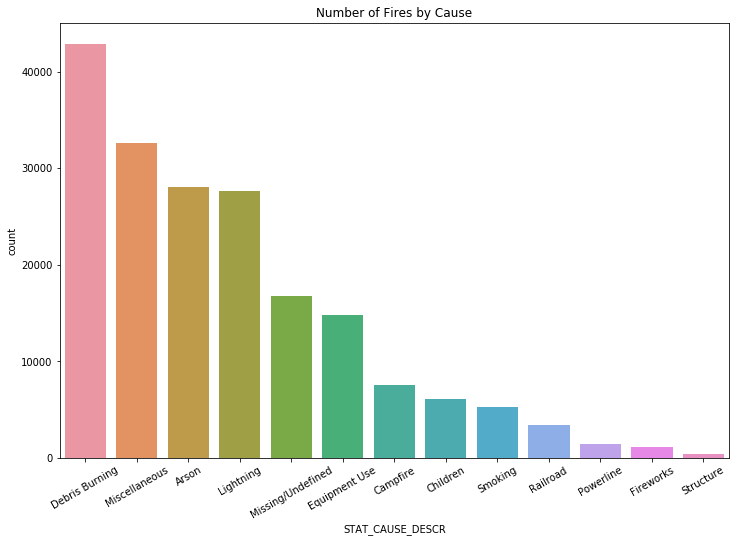

In [6]:
fig = plt.figure(figsize=(12,8))
fire_cause_plot = sns.countplot(x='STAT_CAUSE_DESCR', 
                                data=fires_sample, 
                                order=fires_sample.STAT_CAUSE_DESCR.value_counts().index)
fire_cause_plot.set_title('Number of Fires by Cause')
fire_cause_plot.set_xticklabels(fire_cause_plot.get_xticklabels(), rotation=30);

## Feature exploration

### Fire size

A=greater than 0 but less than or equal to 0.25 acres<br />
B=0.26-9.9 acres<br />
C=10.0-99.9 acres<br />
D=100-299 acres<br />
E=300 to 999 acres<br />
F=1000 to 4999 acres<br />
G=5000+ acres

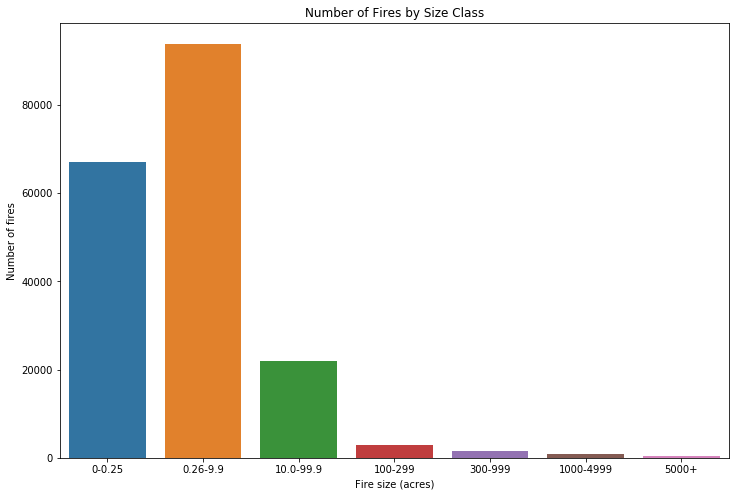

In [7]:
plt.figure(figsize=(12, 8))
fire_size_plot = sns.countplot(x='FIRE_SIZE_CLASS', data=fires_sample, order=['A','B','C','D','E','F','G'])
fire_size_plot.set_title('Number of Fires by Size Class')
fire_size_plot.set_xlabel('Fire size (acres)')
fire_size_plot.set_ylabel('Number of fires')
fire_size_plot.set_xticklabels(['0-0.25', '0.26-9.9', '10.0-99.9', '100-299', '300-999', '1000-4999', '5000+']);

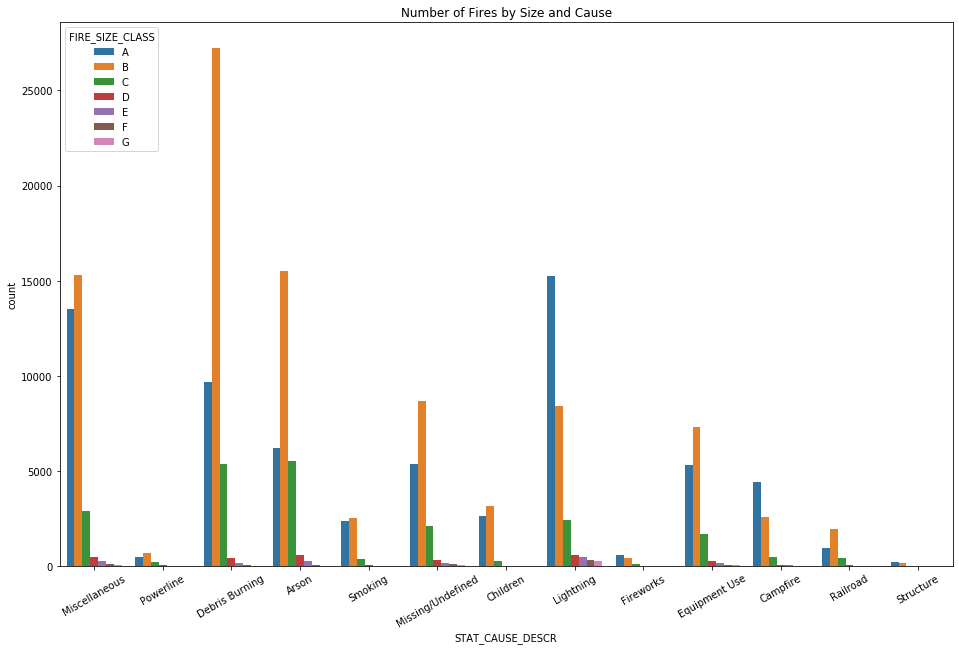

In [8]:
fig = plt.figure(figsize=(16,10))
size_cause_plot = sns.countplot(x='STAT_CAUSE_DESCR',
                                hue='FIRE_SIZE_CLASS',
                                data=fires_sample,
                                hue_order=['A','B','C','D','E','F','G'])
size_cause_plot.set_title('Number of Fires by Size and Cause')
size_cause_plot.set_xticklabels(size_cause_plot.get_xticklabels(), rotation=30);

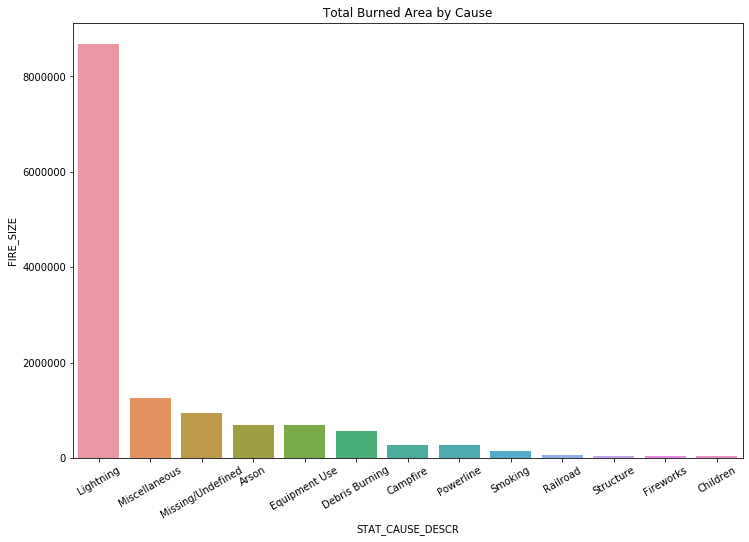

In [9]:
fire_size_by_cause = fires_sample.groupby(['STAT_CAUSE_DESCR'])['FIRE_SIZE'].sum().reset_index()

plt.figure(figsize=(12,8))
fire_size_by_cause_plot = sns.barplot(x='STAT_CAUSE_DESCR', 
                                      y='FIRE_SIZE', 
                                      data=fire_size_by_cause, 
                                      order=fire_size_by_cause.sort_values(by='FIRE_SIZE', ascending=False).STAT_CAUSE_DESCR.tolist())
fire_size_by_cause_plot.set_title('Total Burned Area by Cause')
fire_size_by_cause_plot.set_xticklabels(fire_size_by_cause_plot.get_xticklabels(), rotation=30);

It is shown that the majority of burned area is caused by lightning, which is a natural cause. People may argue that preventing natural fires disturbs the balance of the ecosystem, but as global temperature keeps rising, even natural fires caused by lightning will burn more severely. It is a complicated to figure out whether it is a good idea to mitigate fires no matter the cause, but for the purpose of analyzing wildfires, we will keep going.

### Latitude and longitude

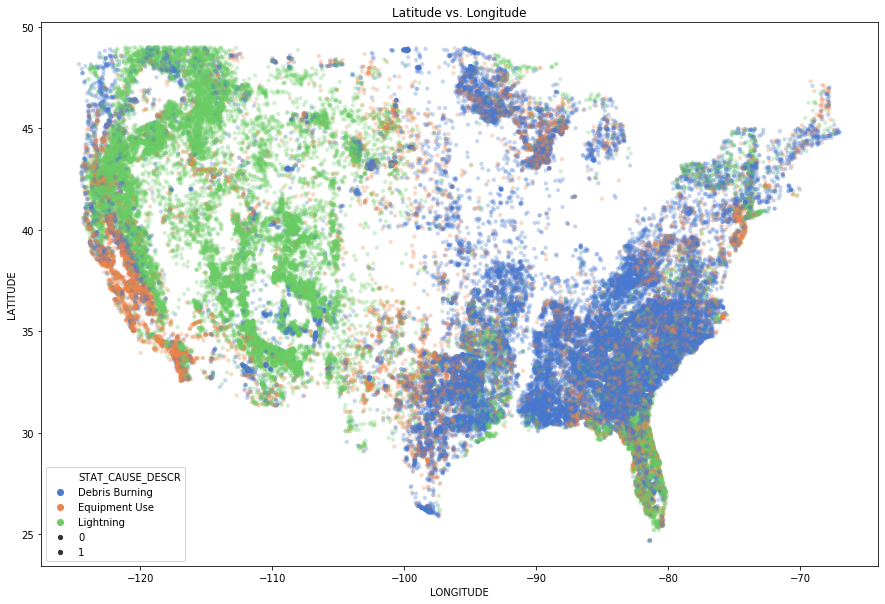

In [10]:
plt.figure(figsize=(15,10))
lat_lon_plot = sns.scatterplot(x='LONGITUDE',
                               y='LATITUDE',
                               data=fires[(fires['LONGITUDE']>-127) & 
                                          (fires['LONGITUDE']<-60) & 
                                          (fires['LATITUDE']<50) &
                                          (fires['LATITUDE']>22) &
                                          ((fires['STAT_CAUSE_DESCR']=='Lightning') |
                                           (fires['STAT_CAUSE_DESCR']=='Debris Burning') |
                                           (fires['STAT_CAUSE_DESCR']=='Equipment Use'))
                                         ].sample(80000),
                               hue='STAT_CAUSE_DESCR',
                               alpha=0.3,
                               size=1,
                               linewidth=0,
                               palette='muted')
lat_lon_plot.set_title('Latitude vs. Longitude');

### Fire year

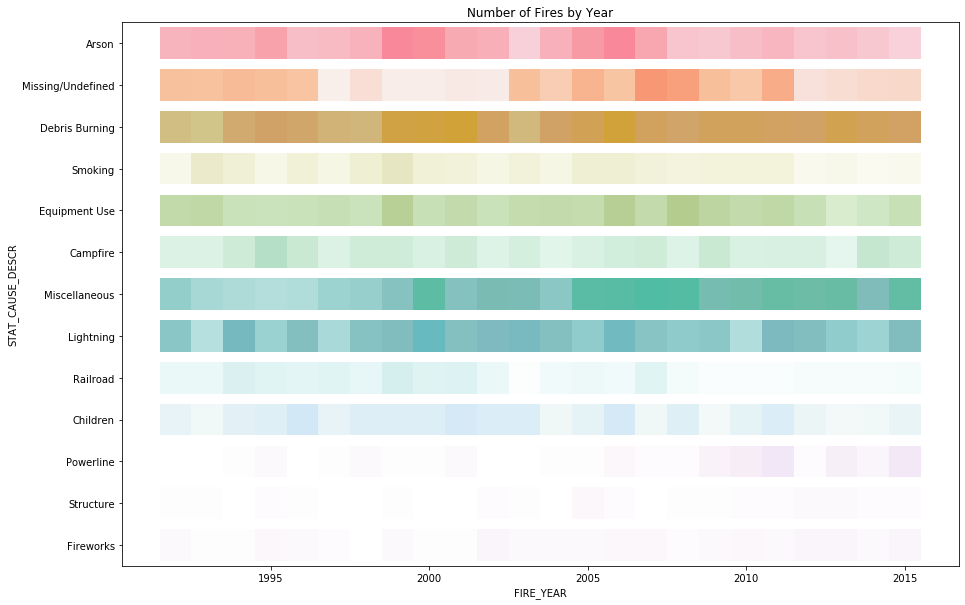

In [11]:
plt.figure(figsize=(15,10))
fire_by_year_plot = sns.stripplot(x='FIRE_YEAR', 
                                  y='STAT_CAUSE_DESCR', 
                                  data=fires.sample(10000), 
                                  size=31.7, 
                                  marker='s', 
                                  alpha=0.01,
                                  jitter=False)
fire_by_year_plot.set_title('Number of Fires by Year');

### Fire discovery day of year

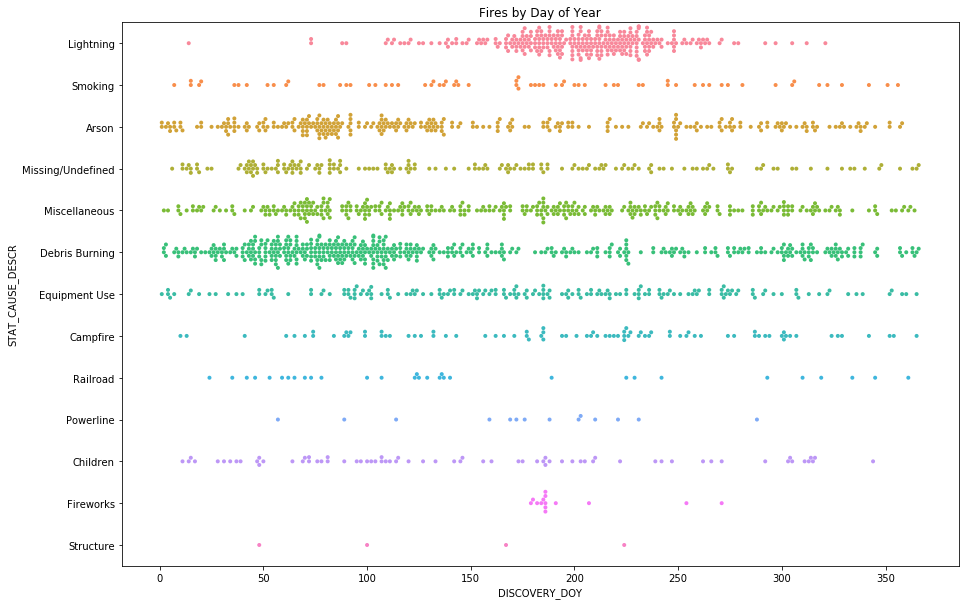

In [12]:
plt.figure(figsize=(15,10))
doy_cause_plot = sns.swarmplot(x='DISCOVERY_DOY', y='STAT_CAUSE_DESCR', data=fires.sample(2000), size=4)
doy_cause_plot.set_title('Fires by Day of Year');

### Fire discovery time of day

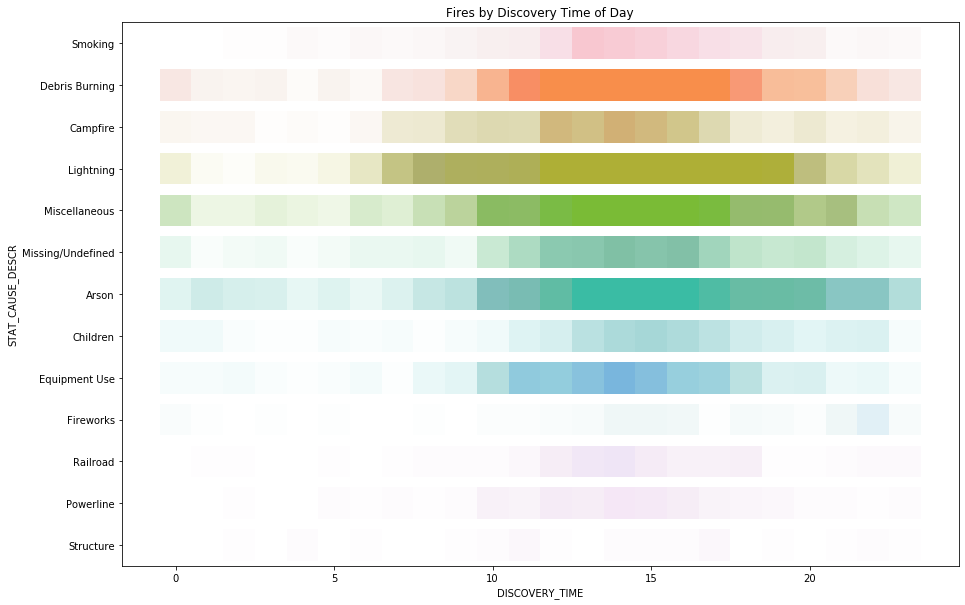

In [13]:
# drop missing DISCOVERY_TIME
fires_sample_with_time = fires_sample.dropna(subset=['DISCOVERY_TIME']).copy()
fires_sample_with_time['DISCOVERY_TIME'] = fires_sample_with_time['DISCOVERY_TIME'].astype(str).str[:2].astype(int)

plt.figure(figsize=(15,10))
time_cause_plot = sns.stripplot(x='DISCOVERY_TIME',
                                y='STAT_CAUSE_DESCR',
                                data=fires_sample_with_time.sample(10000), 
                                size=31.7, 
                                marker='s',
                                alpha=0.01,
                                jitter=False)
time_cause_plot.set_title('Fires by Discovery Time of Day');

The graph shows the relationship between fire discovery time of day and fire cause. DISCOVERY_TIME can be a helpful feature, however, there is too much missing data for the DISCOVERY_TIME column. If I only choose to use columns where DISCOVERY_TIME is not null, the rest of the data will be represented inaccurately. Maybe those where DISCOVERY_TIME is missing tend to be larger fires caused by lightning in remote areas.

## Select features

In [14]:
features = ['FIRE_YEAR', 'FIRE_SIZE', 'DISCOVERY_DOY', 'LATITUDE', 'LONGITUDE']
X = fires_sample[features]
y = fires_sample['STAT_CAUSE_DESCR']

train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)

## Preliminary assessment of machine learning algorithms

In [15]:
# Decision tree
dt_model = DecisionTreeClassifier(random_state=1)
dt_model.fit(train_X, train_y)
dt_prediction = dt_model.predict(val_X)

print('Decision tree accuracy:', metrics.accuracy_score(val_y, dt_prediction))


# Random forest
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(train_X, train_y)
rf_prediction = rf_model.predict(val_X)

print('Random forest accuracy:', metrics.accuracy_score(val_y, rf_prediction))


# Gradient boosting
gb_model = GradientBoostingClassifier(random_state=1)
gb_model.fit(train_X, train_y)
gb_prediction = gb_model.predict(val_X)

print('Gradient boosting accuracy:', metrics.accuracy_score(val_y, gb_prediction))


# XGBoost
xgb_model = XGBClassifier(random_state=1)
xgb_model.fit(train_X, train_y)
xgb_prediction = xgb_model.predict(val_X)

print('XGBoost accuracy:', metrics.accuracy_score(val_y, xgb_prediction))


# KNN
knn_model = KNeighborsClassifier()
knn_model.fit(train_X, train_y)
knn_prediction = knn_model.predict(val_X)

print('KNN accuracy:', metrics.accuracy_score(val_y, knn_prediction))

Decision tree accuracy: 0.4297527253390056
Random forest accuracy: 0.5064344589204999
Gradient boosting accuracy: 0.4810688646636533
XGBoost accuracy: 0.46027652220154214
KNN accuracy: 0.4217495346982186


## Compare preliminary results
Looking at sample results for each algorithm helps with the understanding of data.

In [16]:
pd.DataFrame({'actual cause': val_y,
              'decision tree': dt_prediction,
              'random forest': rf_prediction,
              'gradient boosting':gb_prediction,
              'xgboost': xgb_prediction,
              'knn':knn_prediction}).sample(20)

,actual cause,decision tree,random forest,gradient boosting,xgboost,knn
1709513,Missing/Undefined,Missing/Undefined,Missing/Undefined,Missing/Undefined,Missing/Undefined,Missing/Undefined
258717,Debris Burning,Arson,Debris Burning,Arson,Arson,Arson
263223,Fireworks,Lightning,Lightning,Fireworks,Fireworks,Lightning
1587716,Children,Debris Burning,Debris Burning,Debris Burning,Debris Burning,Debris Burning
316292,Campfire,Debris Burning,Miscellaneous,Miscellaneous,Miscellaneous,Campfire
984931,Debris Burning,Railroad,Railroad,Railroad,Railroad,Debris Burning
124057,Lightning,Lightning,Lightning,Lightning,Lightning,Lightning
964930,Railroad,Equipment Use,Equipment Use,Equipment Use,Railroad,Debris Burning
548735,Miscellaneous,Arson,Arson,Arson,Arson,Children
659271,Missing/Undefined,Campfire,Lightning,Lightning,Lightning,Lightning


It seems like predicting some of these causes are not really that helpful. The purpose of this project is to speed up the process to decide the cause of a fire. When the cause is Miscellaneous or Missing/Undefined, it does not really make sense to predict for these causes with insufficient data.

## Filter out ambiguous causes (miscellaneous, missing/undefined)

In [17]:
fires_sample_nomisc = fires_sample[(fires_sample['STAT_CAUSE_DESCR']!='Miscellaneous') &
                                   (fires_sample['STAT_CAUSE_DESCR']!='Missing/Undefined')]

X = fires_sample_nomisc[features]
y = fires_sample_nomisc['STAT_CAUSE_DESCR']

train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)

# Full dataset
fires_nomisc = fires[(fires['STAT_CAUSE_DESCR']!='Miscellaneous') &
                     (fires['STAT_CAUSE_DESCR']!='Missing/Undefined')]

X_full = fires_nomisc[features]
y_full = fires_nomisc['STAT_CAUSE_DESCR']

train_X_full, val_X_full, train_y_full, val_y_full = train_test_split(X_full, y_full, train_size=0.8, test_size=0.2, random_state=1)

In [21]:
# Decision tree
dt_model = DecisionTreeClassifier(random_state=1)
dt_model.fit(train_X, train_y)
dt_prediction = dt_model.predict(val_X)

print('Decision tree accuracy:', metrics.accuracy_score(val_y, dt_prediction))


# Random forest
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(train_X, train_y)
rf_prediction = rf_model.predict(val_X)

print('Random forest accuracy:', metrics.accuracy_score(val_y, rf_prediction))


# Gradient boosting
gb_model = GradientBoostingClassifier(random_state=1)
gb_model.fit(train_X, train_y)
gb_prediction = gb_model.predict(val_X)

print('Gradient boosting accuracy:', metrics.accuracy_score(val_y, gb_prediction))


# XGBoost
xgb_model = XGBClassifier(random_state=1)
xgb_model.fit(train_X, train_y)
xgb_prediction = xgb_model.predict(val_X)

print('XGBoost accuracy:', metrics.accuracy_score(val_y, xgb_prediction))


# KNN
knn_model = KNeighborsClassifier()
knn_model.fit(train_X, train_y)
knn_prediction = knn_model.predict(val_X)

print('KNN accuracy:', metrics.accuracy_score(val_y, knn_prediction))

Decision tree accuracy: 0.45736629667003026
Random forest accuracy: 0.5404353466916535
Gradient boosting accuracy: 0.5379847196194321
XGBoost accuracy: 0.5273533227620009
KNN accuracy: 0.47787227908317714


Random forest and gradient boosting achieve the highest accuracy with default settings. In the next section, we will focus on fine tuning these two algorithms.

## Fine tune random forest

### Randomized search

In [43]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [46]:
rf = RandomForestClassifier()
rand_search = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 50, 
                               cv = 3, 
                               verbose=2, 
                               random_state=1, 
rand_search.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 45.5min
//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 180.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [49]:
rand_search.best_params_

{'n_estimators': 700,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': True}

In [18]:
rf_model_best_random = RandomForestClassifier(random_state=1, 
                                              n_estimators=700, 
                                              max_depth=80, 
                                              max_features='auto', 
                                              min_samples_split=5, 
                                              min_samples_leaf=4,
                                              bootstrap=True)
rf_model_best_random.fit(train_X, train_y)
rf_prediction_best_random = rf_model_best_random.predict(val_X)

print('Accuracy:', metrics.accuracy_score(val_y, rf_prediction_best_random))

Accuracy: 0.57759117774254


### Grid search

In [163]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [75, 80, 85, 150],
    'max_features': ['auto'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [700, 1000]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X, y)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 49.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 211.3min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 291.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [167]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 75,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 6,
 'n_estimators': 700}

### Apply the best parameters

In [19]:
rf_model_best_grid = RandomForestClassifier(random_state=1, 
                                              n_estimators=700, 
                                              max_depth=75, 
                                              max_features='auto', 
                                              min_samples_split=6, 
                                              min_samples_leaf=3,
                                              bootstrap=True)
rf_model_best_grid.fit(train_X, train_y)
rf_prediction_best_grid = rf_model_best_grid.predict(val_X)

print('Accuracy when applied to 10% of the data:', metrics.accuracy_score(val_y, rf_prediction_best_grid))

rf_model_best_grid.fit(train_X_full, train_y_full)
rf_prediction_best_grid = rf_model_best_grid.predict(val_X_full)

print('Accuracy when applied to the full dataset:', metrics.accuracy_score(val_y_full, rf_prediction_best_grid))

Accuracy when applied to 10% of the data: 0.579140838979386
Accuracy when applied to the full dataset: 0.6255989467171245


## Fine tune gradient boosting

### Randomized search

In [23]:
# Number of trees in random forest
n_estimators = [100, 300, 500, 700, 900]
# Learning rate
learning_rate = [0.15, 0.1, 0.05, 0.01, 0.005, 0.001]
# Maximum number of levels in tree
max_depth = [3, 5, 10, 20, 40, 60, 80]
# Number of features to consider at every split
max_features = ['sqrt']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'n_estimators': [100, 300, 500, 700, 900], 'learning_rate': [0.15, 0.1, 0.05, 0.01, 0.005, 0.001], 'max_depth': [3, 5, 10, 20, 40, 60, 80], 'max_features': ['sqrt'], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [ ]:
gb = GradientBoostingClassifier()
rand_search = RandomizedSearchCV(estimator = gb, 
                                 param_distributions = random_grid, 
                                 n_iter = 30, 
                                 cv = 3, 
                                 verbose=2, 
                                 random_state=1) 
rand_search.fit(X, y)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, learning_rate=0.001 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, learning_rate=0.001, total=320.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 320.3min remaining:    0.0s


[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, learning_rate=0.001 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, learning_rate=0.001, total=334.4min
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, learning_rate=0.001 


In [ ]:
rand_search.best_params_

In [ ]:
gb_model_best_random = GradientBoostingClassifier(random_state=1, 
                                              n_estimators=700, 
                                              learning_rate=0.1,
                                              max_depth=80, 
                                              max_features='sqrt', 
                                              min_samples_split=5, 
                                              min_samples_leaf=4)
gb_model_best_random.fit(train_X, train_y)
gb_prediction_best_random = gb_model_best_random.predict(val_X)

print('Accuracy:', metrics.accuracy_score(val_y, gb_prediction_best_random))